In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.basics import *

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

The dataset is from: 

git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [5]:
path = Path('./SegNet-Tutorial/CamVid')

In [6]:
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/models'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/val'),
 PosixPath('SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/train'),
 PosixPath('SegNet-Tutorial/CamVid/testannot')]

# Data

In [7]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08039.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08105.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08081.png')]

In [8]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08039.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08105.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08081.png')]

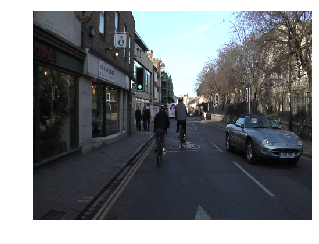

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

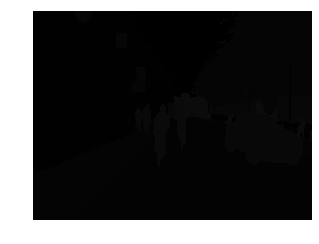

In [10]:
anno_f = Path(str(img_f.parent)+'annot')/img_f.name
anno = open_image(anno_f)
anno.show(figsize=(5,5))

In [11]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

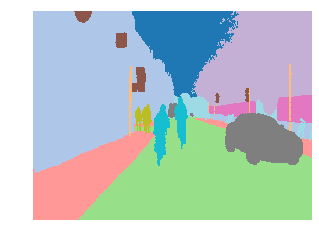

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

# Getting them into a DataBunch

In [14]:
bs, size = 8, src_size//2

In [15]:
src = (SegmentationItemList.from_folder(path)
      .split_by_folder(valid='val')
      .label_from_func(get_y_fn, classes=codes))

In [16]:
src

LabelLists;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: SegNet-Tutorial/CamVid;

Test: None

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

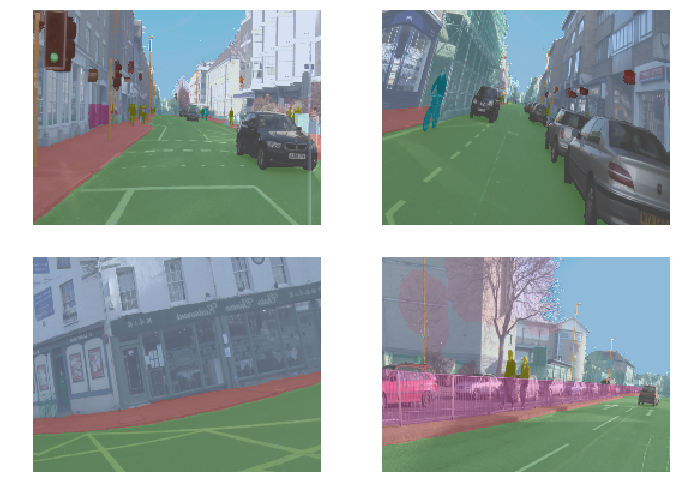

In [20]:
data.show_batch(2, figsize=(10,7))

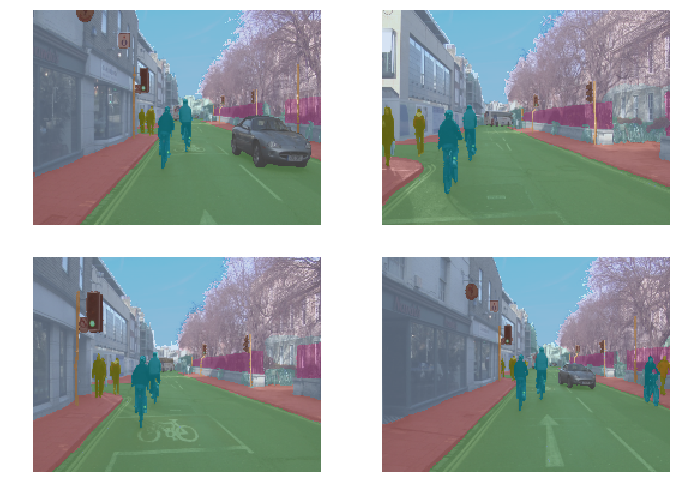

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [22]:
name2id

{'Sky': 0,
 'Building': 1,
 'Pole': 2,
 'Road': 3,
 'Sidewalk': 4,
 'Tree': 5,
 'Sign': 6,
 'Fence': 7,
 'Car': 8,
 'Pedestrian': 9,
 'Cyclist': 10,
 'Void': 11}

In [23]:
metrics=acc_camvid
wd=1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-04


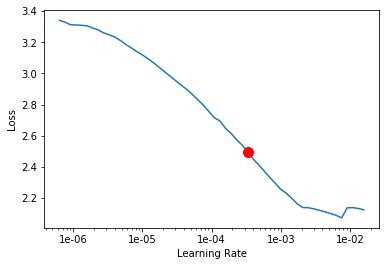

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
lr = 3e-04

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.842899,1.491374,0.586292
2,1.279489,0.964874,0.752649
3,0.954152,0.726524,0.819947
4,0.745064,0.615723,0.835394
5,0.630627,0.515915,0.858604
6,0.570758,0.600053,0.834042
7,0.514748,0.452694,0.861972
8,0.487172,0.403537,0.879488
9,0.443488,0.370033,0.889871
10,0.407654,0.348062,0.893359


In [28]:
learn.save('stage-1')

In [38]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240)
y: SegmentationLabelList
ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240)
Path: SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240)
y: SegmentationLabelList
ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240)
Path: SegNet-Tutorial/CamVid;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
  

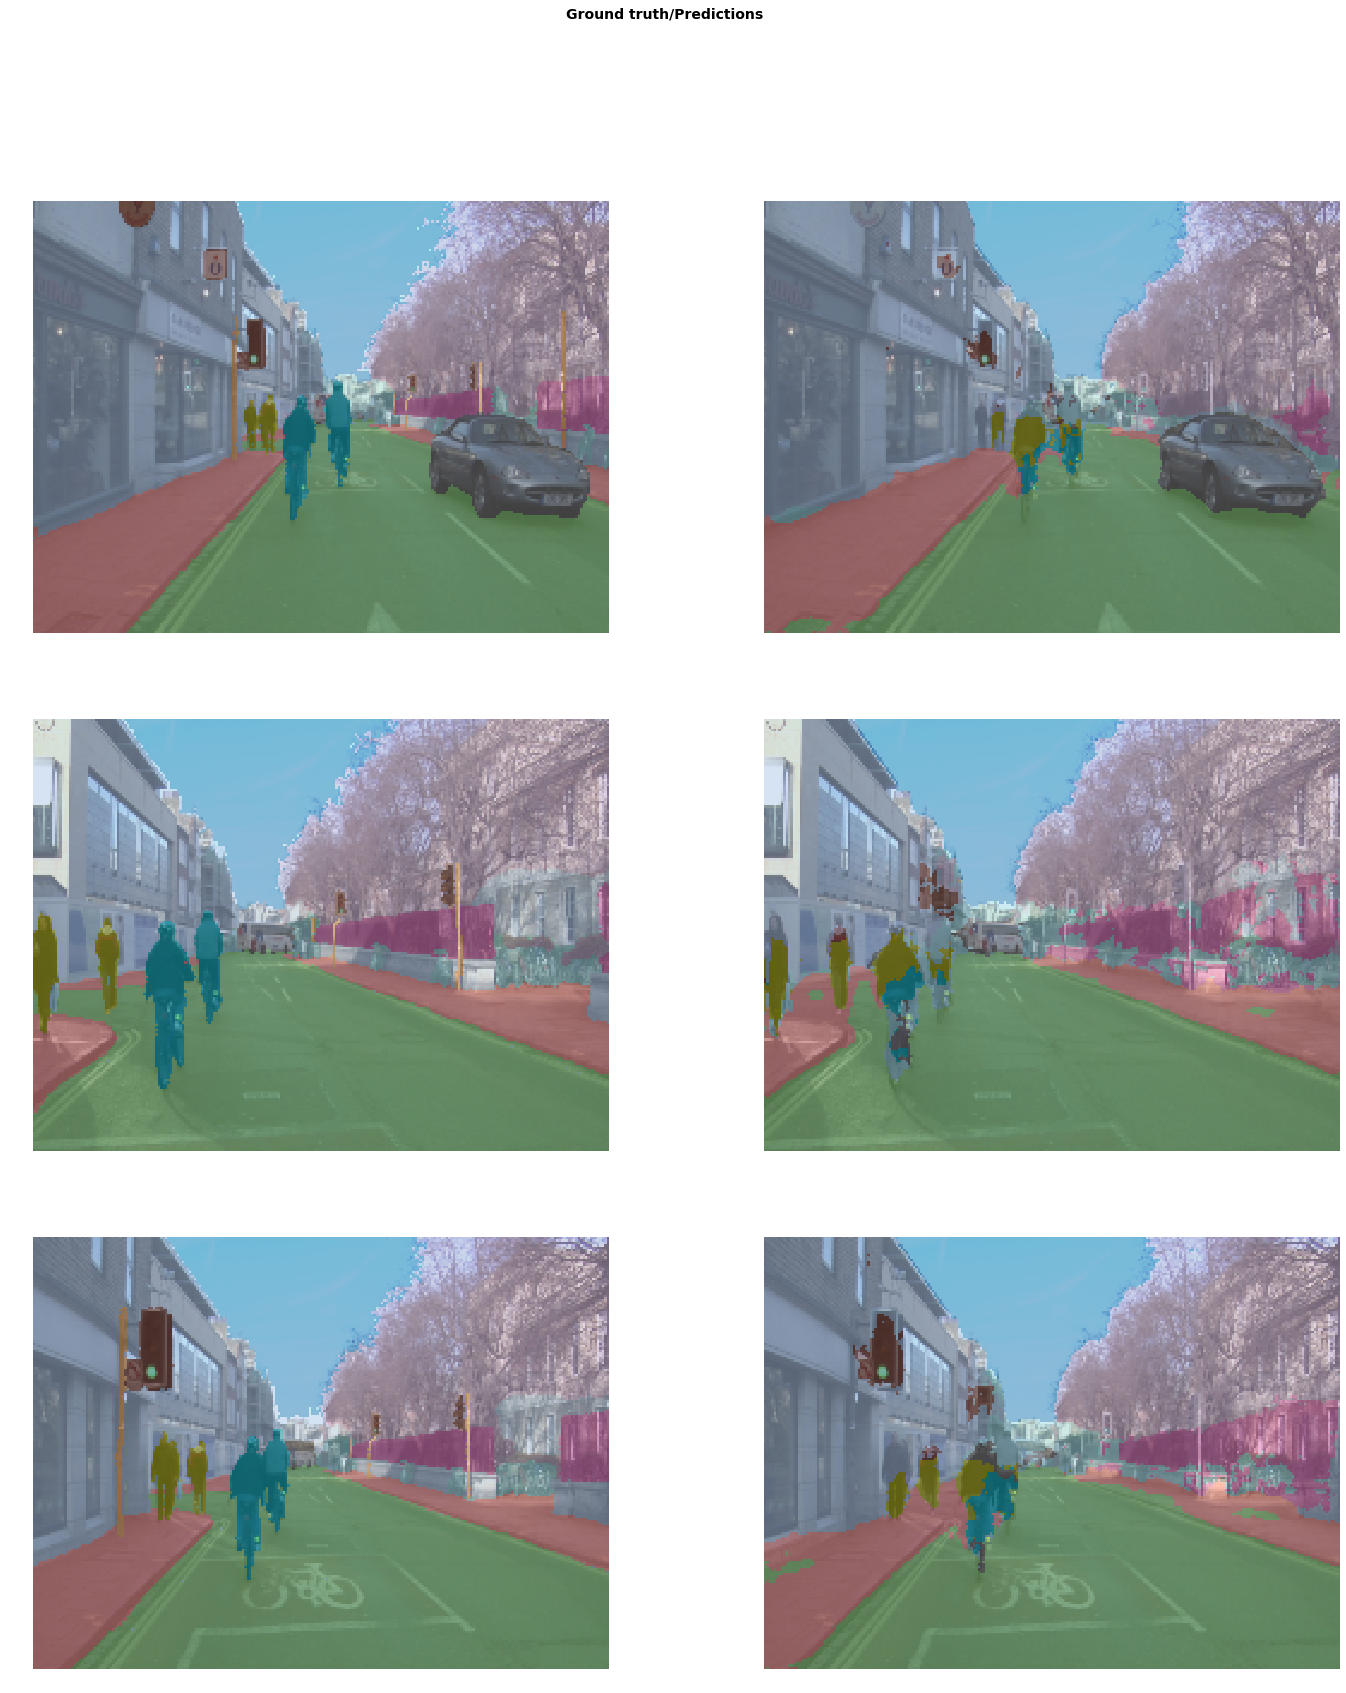

In [32]:
learn.show_results(rows=3, figsize=(24,27))

In [39]:
learn.unfreeze()

In [40]:
lrs = slice(lr/400, lr/4)

In [41]:
learn.fit_one_cycle(18, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.345415,0.328886,0.900341
2,0.342072,0.323417,0.902502
3,0.337014,0.317629,0.904441
4,0.337881,0.330314,0.898093
5,0.332113,0.307318,0.909155
6,0.327165,0.313587,0.906944
7,0.323718,0.317287,0.905788
8,0.318449,0.313503,0.906387
9,0.318514,0.310388,0.906193
10,0.313430,0.301969,0.912509


In [43]:
learn.save('stage-2')

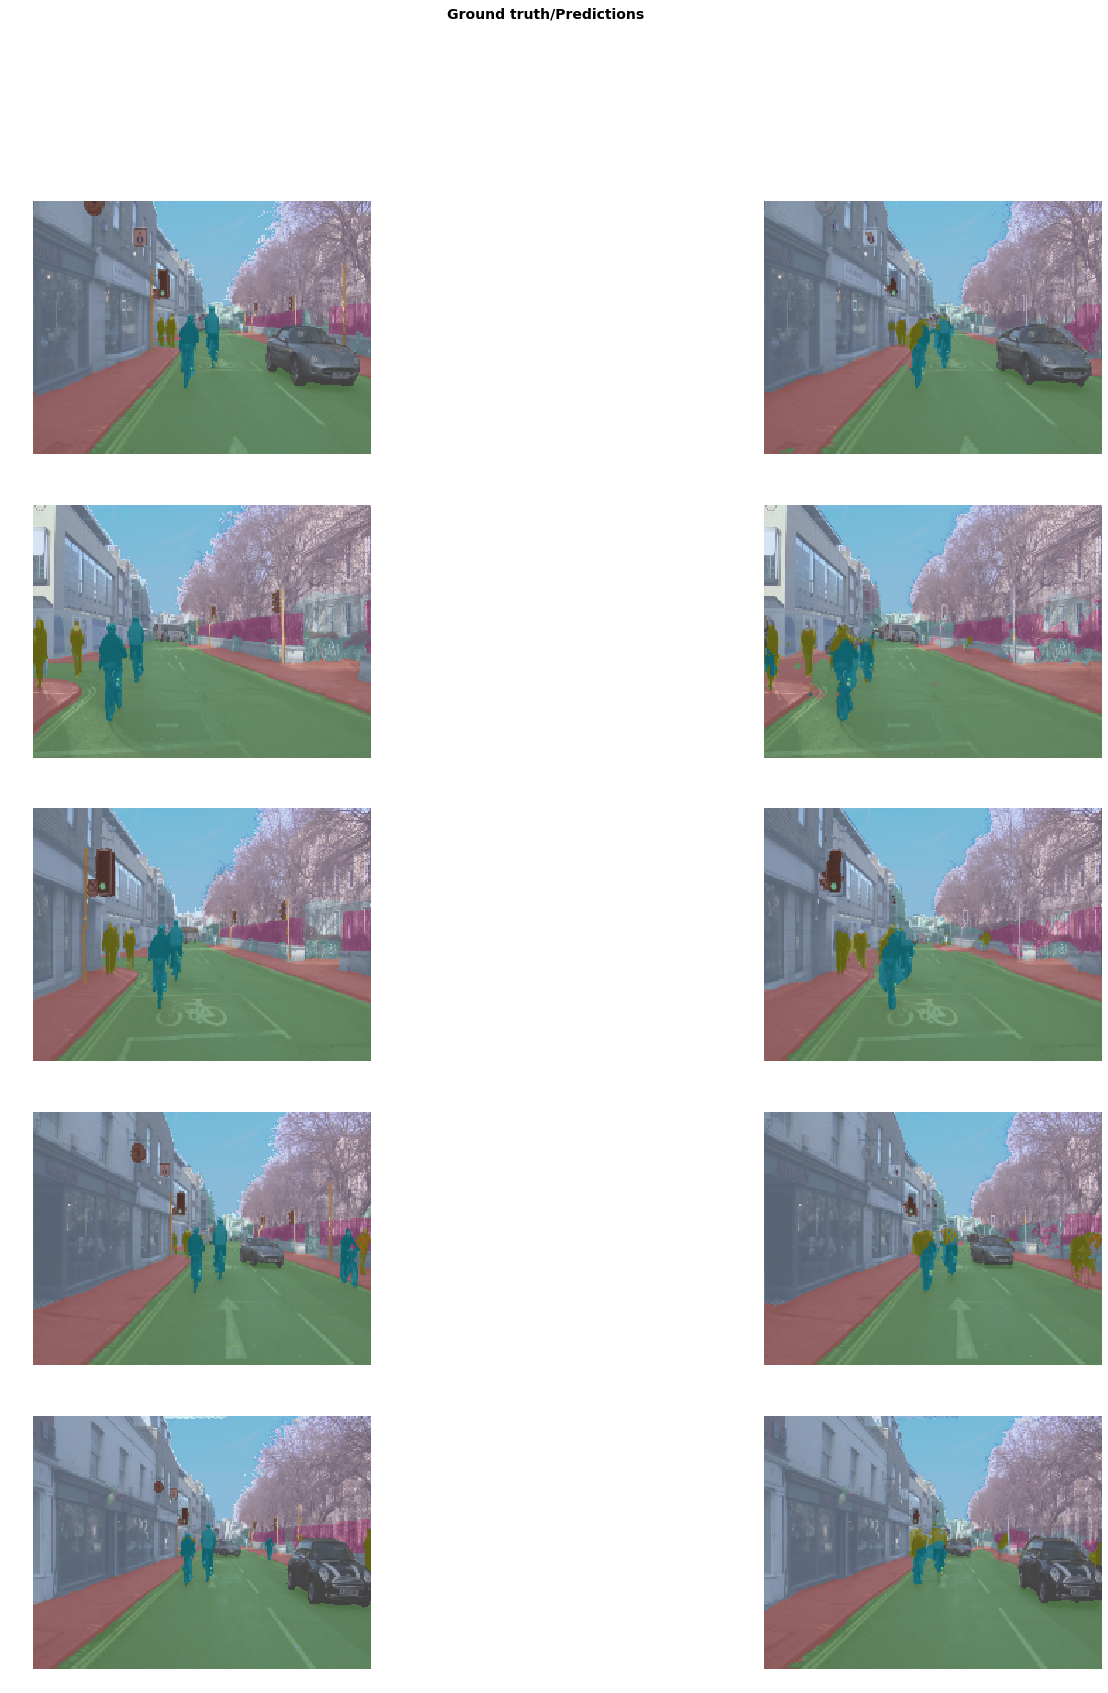

In [42]:
learn.show_results(rows=5, figsize=(24,27))

# Wrong notebook :(. Do it again

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/luan/.fastai/data/camvid/images'),
 PosixPath('/home/luan/.fastai/data/camvid/labels'),
 PosixPath('/home/luan/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/luan/.fastai/data/camvid/codes.txt')]

In [6]:
path_lbl = path/'labels'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/luan/.fastai/data/camvid/images/0006R0_f01860.png'),
 PosixPath('/home/luan/.fastai/data/camvid/images/Seq05VD_f04980.png'),
 PosixPath('/home/luan/.fastai/data/camvid/images/0016E5_08039.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/luan/.fastai/data/camvid/labels/0016E5_08490_P.png'),
 PosixPath('/home/luan/.fastai/data/camvid/labels/Seq05VD_f01230_P.png'),
 PosixPath('/home/luan/.fastai/data/camvid/labels/Seq05VD_f05010_P.png')]

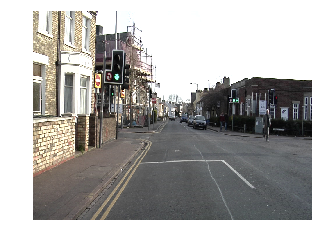

In [9]:
# Sample image
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

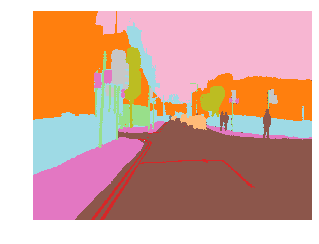

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [14]:
size = src_size//2
bs = 4

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
src

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/luan/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/luan/.fastai/data/camvid/images;

Test: None

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

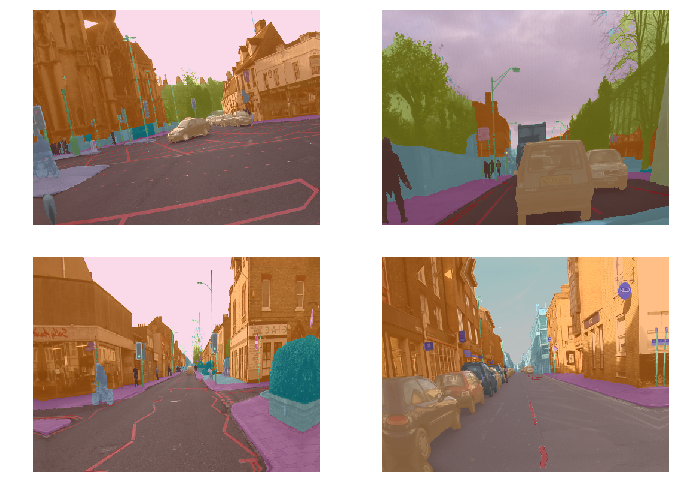

In [18]:
data.show_batch(2, figsize=(10,7))

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics=acc_camvid
# metrics=accuracy

In [21]:
wd = 1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04


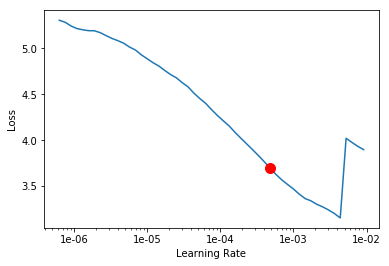

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr = 4e-04

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,1.382071,0.964391,0.785365
2,0.861718,0.733176,0.829786
3,0.679595,0.596247,0.842809
4,0.616262,0.627355,0.816504
5,0.601185,0.662153,0.832261
6,0.521482,0.428395,0.885450
7,0.513716,0.405562,0.892753
8,0.490697,0.356345,0.898494
9,0.451220,0.399567,0.890152
10,0.363713,0.297938,0.913909


In [26]:
learn.save('stage-1')

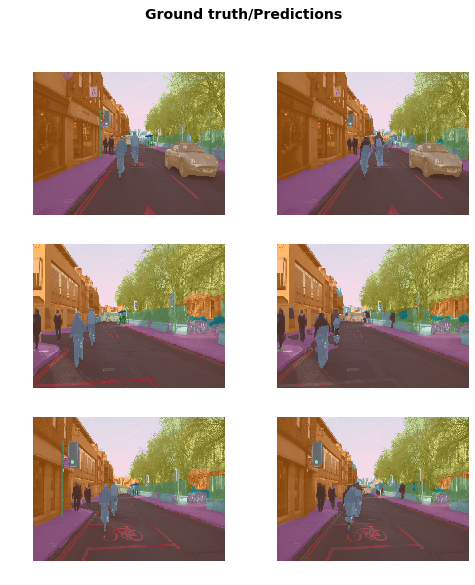

In [27]:
learn.show_results(rows=3, figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.319819,0.294471,0.914426
2,0.319204,0.284234,0.917941
3,0.320299,0.277665,0.920797
4,0.313524,0.289135,0.916238
5,0.306823,0.297975,0.912896
6,0.302479,0.298298,0.912032
7,0.295714,0.286908,0.916269
8,0.287804,0.277616,0.920512
9,0.286069,0.292678,0.915709
10,0.269957,0.278043,0.921389


In [31]:
learn.save('stage-2')